In [15]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image, ImageDraw
import os
import pandas as pd

In [13]:
def gather_data(path: str) -> pd.DataFrame:
    image_ids = []
    bbox_left = []
    bbox_top = []
    bbox_right = []
    bbox_bottom = []
    classes = []

    for item in os.listdir(path + "/image"): # look at every image in path
        image_id = item.split(".")[0] # split on file extension and just get id
        
        with open(f"{path}/label/{image_id}.txt", "r") as f:
            for line in f.readlines():
                split_line = line.split(" ")
                
                image_ids.append(image_id)

                # each bbox is defined as (class left top right bottom) as a new line in the corresponding .txt file

                classes.append(split_line[0].strip())
                bbox_left.append(split_line[1].strip())
                bbox_top.append(split_line[2].strip())
                bbox_right.append(split_line[3].strip())
                bbox_bottom.append(split_line[4].strip("\n"))

    df = pd.DataFrame(data={
        "image_id": image_ids,
        "bbox_left": bbox_left,
        "bbox_top": bbox_top,
        "bbox_right": bbox_right,
        "bbox_bottom": bbox_bottom,
        "class": classes
    })

    return df

In [14]:
df = gather_data("crowd4access-images/crowd4access-images/trainval")
df.head()

,image_id,bbox_left,bbox_top,bbox_right,bbox_bottom,class
0,jiYLJwXmVXuZKQA9N6O7v3,515,288,835,438,tactile_surface
1,0q6mFPlnqbVkUG1azCIcnA,447,431,685,491,tactile_surface
2,0q6mFPlnqbVkUG1azCIcnA,719,412,819,432,tactile_surface
3,hbcZ1FfLcwudenW4PLHJ9h,731,288,1017,431,tactile_surface
4,nA4vzxw0BdqNTRHk1G9Qjw,456,277,642,336,tactile_surface


In [74]:
def draw_example(index: int) -> Image:
    filename = df["image_id"][index]
    image = Image.open(f"crowd4access-images/crowd4access-images/trainval/image/{filename}.jpg")

    draw = ImageDraw.Draw(image, "RGBA")

    left = float(df["bbox_left"][index])
    top = float(df["bbox_top"][index])
    right = float(df["bbox_right"][index])
    bottom = float(df["bbox_bottom"][index])

    draw.rectangle([(left, top), (right, bottom)])

    return image

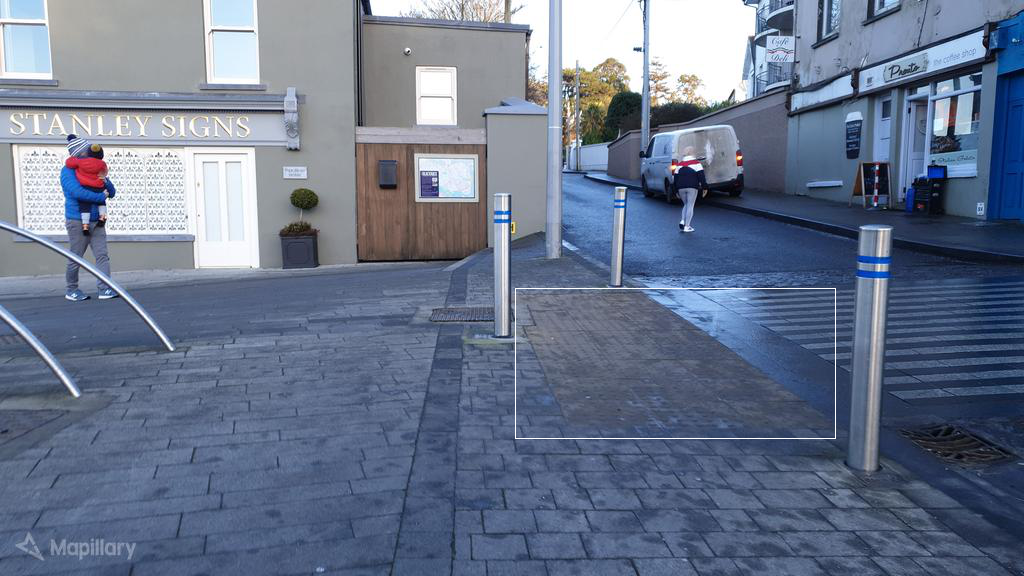

In [75]:
draw_example(0)

In [4]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

Downloading: 100%|██████████| 4.48k/4.48k [00:00<00:00, 809kB/s]
Downloading: 100%|██████████| 159M/159M [00:53<00:00, 3.13MB/s] 
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /home/dadofapollo/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


In [5]:
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

/home/dadofapollo/miniconda3/envs/tactile-paving/lib/python3.7/site-packages/transformers/models/detr/modeling_detr.py:422: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.embedding_dim)


In [27]:
outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])

In [ ]:
def process_example(example):
    inputs = feature_extractor(example["image"], return_tensors="pt")
    inputs["pred_boxes"] = 